# Neural network Keras version for ML CUP

## Imports

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import tensorflow.keras.backend as K

## Utils

In [26]:
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy from a model's history, 
    adding the parameters as a title.

    Parameters:
    ---------
    - history: History object returned by model.fit().
    """

    # Extract data from the history object
    train_loss = history.history['loss']  # Training loss (MSE)
    val_loss = history.history.get('val_loss', [])  # Validation loss (MSE), if available
    train_mee = history.history.get('mean_euclidean_error', [])  # Training Mean Euclidean Error (MEE)
    val_mee = history.history.get('val_mean_euclidean_error', [])  # Validation Mean Euclidean Error (MEE), if available
    
    # Number of epochs
    epochs = range(1, len(train_loss) + 1)

    # Plotting the Loss
    plt.figure(figsize=(12, 5))  # Create a figure with a specific size
    plt.subplot(1, 2, 1)  # Create a subplot (1 row, 2 columns, 1st plot)
    plt.plot(epochs, train_loss, 'b-o', label='Training MSE')  # Plot training loss
    if val_loss:
        plt.plot(epochs, val_loss, 'r-o', label='Validation MSE')  # Plot validation loss if available
    plt.title('Training and Validation MSE')  # Title of the plot
    plt.xlabel('Epochs')  # X-axis label
    plt.ylabel('MSE')  # Y-axis label
    plt.legend()  # Show legend
    plt.grid(True)  # Show grid

    # Plotting the Mean Euclidean Error (MEE)
    plt.subplot(1, 2, 2)  # Create a subplot (1 row, 2 columns, 2nd plot)
    if train_mee:
        plt.plot(epochs, train_mee, 'b-o', label='Training MEE')  # Plot training MEE
    if val_mee:
        plt.plot(epochs, val_mee, 'r-o', label='Validation MEE')  # Plot validation MEE if available
    plt.title('Training and Validation MEE')  # Title of the plot
    plt.xlabel('Epochs')  # X-axis label
    plt.ylabel('MEE')  # Y-axis label
    plt.legend()  # Show legend
    plt.grid(True)  # Show grid
    
    # Adjust layout and show the plot
    plt.show()

In [27]:
def generate_hyperparameter_combinations(param_ranges):
    """
    Generate all combinations of hyperparameters based on specified ranges and steps.

    Parameters
    ---------
    - param_ranges: Dictionary with hyperparameter names as keys.
                         Each value is a tuple (start, stop, step).

    Returns
    ---------
    - List of dictionaries with all possible combinations.
    """
    # Create a dictionary where each key is a hyperparameter name and each value is an array of possible values
    param_values = {
        key: np.arange(start, stop + step, step)  # Generate values from start to stop with the given step
        for key, (start, stop, step) in param_ranges.items()
    }
    
    # Generate all possible combinations of hyperparameter values
    param_combinations = list(itertools.product(*param_values.values()))
    
    # Convert each combination from a tuple to a dictionary
    return [
        dict(zip(param_values.keys(), combination))  # Create a dictionary for each combination
        for combination in param_combinations
    ]

In [28]:
def mean_euclidean_error(y_true, y_pred):
    """
    Mean Euclidean Error (MEE) calculation.

    Parameters:
    --------
    -    y_true: True target values.
    -    y_pred: Predicted target values.

    Returns:
    --------
    - float: Mean Euclidean Error.
    """
    return K.mean(K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1)))

## Data load

In [29]:
# Load dataset
train_path = '../Datasets/CUP/ML-CUP24-TR.csv'  # Path to the training dataset
test_path = '../Datasets/CUP/ML-CUP24-TS.csv'   # Path to the test dataset
data_train = pd.read_csv(train_path, skiprows=7)  # Load the training data, skipping the first 7 rows
data_blind_test = pd.read_csv(test_path, skiprows=7)    # Load the test data, skipping the first 7 rows

# Drop the ID column and split inputs/outputs for training data
X_train = data_train.iloc[:, 1:-3].values  # Extract input features (all columns except the first and last three)
y_train = data_train.iloc[:, -3:].values   # Extract target values (last three columns: TARGET_x, TARGET_y, TARGET_z)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Drop the ID column and split inputs/outputs for test data
X_blind_test = data_blind_test.iloc[:, 1:].values  # Extract input features (all columns except the first)

# Standardize inputs (mean 0, std 1)
input_scaler = StandardScaler()  # Initialize the StandardScaler for input features
X_train_scaled = input_scaler.fit_transform(X_train)  # Fit the scaler on training data and transform it
X_test_scaled = input_scaler.transform(X_test)  
X_blind_test_scaled = input_scaler.transform(X_blind_test)        # Transform the test data using the same scaler

# Normalize outputs (Min-Max scaling to [0, 1])
output_scaler = MinMaxScaler()  # Initialize the MinMaxScaler for output values
y_train_scaled = output_scaler.fit_transform(y_train)  # Fit the scaler on training target values and transform them
y_test_scaled = output_scaler.transform(y_test)


## Model creation

In [30]:
def create_nn(input_dim, output_dim=3, activ_type='tanh', optim_type='SGD', reg_flag=False, learning_rate=0.01,
              hidden_size=6, hidden_layers=1, regularization=0.01, momentum=0.9, alpha=0.01):
    """
    Create a neural network with configurable parameters.
    
    Parameters:
    -----------
    - input_dim (int): Number of input features.
    - output_dim (int): Number of output features.
    - activ_type (str): Activation function type for hidden layers.
    - optim_type (str): Optimizer type ('SGD' or 'Adam').
    - reg_flag (bool): Flag to indicate whether to use regularization.
    - learning_rate (float): Learning rate for the optimizer.
    - hidden_size (int): Number of nodes in each hidden layer.
    - hidden_layers (int): Number of hidden layers.
    - regularization (float): L2 regularization factor.
    - momentum (float): Momentum for the SGD optimizer.
    - alpha (float): Negative slope coefficient for Leaky ReLU.
    
    Returns:
    ----------
    - model (tf.keras.Model): Compiled Keras model.
    """
    model = Sequential()  # Initialize a Sequential model

    # Input layer (using Input layer explicitly)
    model.add(Input(shape=(input_dim,)))  # Define the input layer with the specified input dimension

    # Add hidden layers based on the activation type and regularization flag
    if reg_flag & (activ_type == 'licky_relu'):
        # Hidden layers with Leaky ReLU and L2 regularization
        for _ in range(hidden_layers):
            model.add(Dense(hidden_size, kernel_regularizer=l2(regularization)))  # Add Dense layer with L2 regularization
            model.add(LeakyReLU(negative_slope=alpha))  # Add Leaky ReLU activation with specified negative slope

    elif (not reg_flag) & (activ_type == 'licky_relu'):
        # Hidden layers with Leaky ReLU without regularization
        for _ in range(hidden_layers):
            model.add(Dense(hidden_size))  # Add Dense layer without regularization
            model.add(LeakyReLU(negative_slope=alpha))  # Add Leaky ReLU activation with specified negative slope

    elif reg_flag:
        # Hidden layers with specified activation function and L2 regularization
        for _ in range(hidden_layers):
            model.add(Dense(hidden_size, activation=activ_type, kernel_regularizer=regularizers.l2(regularization)))  # Add Dense layer with activation and L2 regularization

    else:
        # Hidden layers with specified activation function without regularization
        for _ in range(hidden_layers):
            model.add(Dense(hidden_size, activation=activ_type))  # Add Dense layer with activation

    # Output layer
    model.add(Dense(output_dim, activation='linear'))  # Add output layer with linear activation

    # Optimizer
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)  # Initialize SGD optimizer with specified parameters

    if optim_type == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)  # Initialize Adam optimizer if specified

    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error', metrics=['mae', mean_euclidean_error])  # Compile the model with specified loss and metrics
    
    return model  # Return the compiled model

## Double k-fold cross validation

In [31]:
def double_k_fold_cross_validation(data, labels, activ_type = 'tanh', optim_type = 'SGD', reg_flag = False, in_size = 6, out_size=3, outer_k = 5, inner_k = 5, param_grid=None):
    """
    Implements Double K-Fold Cross-Validation

    Parameters
    ---------
     -   data (np.ndarray): Features of the dataset.
     -   labels (np.ndarray): Labels of the dataset.
     -   activ_type (str): Activation function type.
     -   optim_type (str): Optimizer type.
     -   reg_flag (bool): Regularization flag.
     -  in_size (int): Input size.
     -   outer_k (int): Number of folds for outer cross-validation.
     -   inner_k (int): Number of folds for inner cross-validation.
     -   param_grid (list): List of dictionaries with hyperparameters to try.
    
    Returns:
    ----------
     -   list: List of scores obtained for each outer fold.
     -   list: List of best parameters for each outer fold.
    """
    outer_scores = []
    outer_params = []
    
    # Configuration of the outer k-fold cross-validation
    out_kfold = KFold(n_splits=outer_k, shuffle=True, random_state=42)

    # EarlyStopping callback with patience
    early_stopping = EarlyStopping(monitor='val_loss', patience=param_grid[0]['patience'], min_delta = 0.05, restore_best_weights=True)

    # Outer cross-validation loop
    out_fold_no = 1
    for train_index, val_index in out_kfold.split(data):
        
        # Split the dataset into training and validation sets for the outer fold
        out_X_train, out_X_val = data[train_index], data[val_index]
        out_y_train, out_y_val = labels[train_index], labels[val_index]
        
        best_params = {}
        best_score = np.inf

        # Iterate over each set of hyperparameters in the parameter grid
        for params in param_grid:

            inner_scores = []

            # Inner cross-validation loop
            inner_fold_no = 1
            inner_kfold = KFold(n_splits=inner_k, shuffle=True, random_state=42)

            for train_index, val_index in inner_kfold.split(out_X_train):
                
                # Split the dataset into training and validation sets for the inner fold
                inner_X_train, inner_X_val = out_X_train[train_index], out_X_train[val_index]
                inner_y_train, inner_y_val = out_y_train[train_index], out_y_train[val_index]

                # Create the neural network model
                model = create_nn(input_dim=in_size,
                          output_dim=out_size,
                          activ_type=activ_type,
                          optim_type=optim_type,
                          reg_flag=reg_flag,
                          learning_rate=params['learning_rate'], 
                          hidden_size=params['hidden_size'], 
                          hidden_layers=params['hidden_layers'], 
                          regularization=params['regularization'], 
                          momentum=params['momentum'], 
                          alpha=params['alpha'])

                # Train the model and obtain the history
                history = model.fit(inner_X_train,
                                    inner_y_train,
                                    epochs=params['epochs'],
                                    batch_size=params['batch_size'],
                                    validation_data=(inner_X_val, inner_y_val), 
                                    verbose=0,
                                    callbacks=[early_stopping])
                    
                # Append the minimum validation mean euclidean error to inner scores
                inner_scores.append(min(history.history['val_mean_euclidean_error']))
                inner_fold_no += 1
            
            # Calculate the average score for the current set of hyperparameters
            avg_score = np.mean(inner_scores)

            # Update the best score and parameters if the current average score is better
            if avg_score < best_score:
                best_score = avg_score
                best_params = params
        
        # Train the final model on the outer training set with the best hyperparameters
        final_model = create_nn(input_dim = in_size,
                                output_dim=out_size,
                                activ_type = activ_type,
                                optim_type = optim_type,
                                reg_flag = reg_flag, 
                                learning_rate=best_params['learning_rate'],
                                hidden_size = best_params['hidden_size'], 
                                hidden_layers = best_params['hidden_layers'],
                                regularization=best_params['regularization'],
                                momentum=best_params['momentum'],
                                alpha=best_params['alpha'])
        
        # Train the final model and obtain the history
        history = final_model.fit(out_X_train, out_y_train,
                                epochs=best_params['epochs'],
                                batch_size=best_params['batch_size'],
                                validation_data=(out_X_val, out_y_val),
                                verbose=0,
                                callbacks=[early_stopping])
        
        # Append the minimum validation mean euclidean error to outer scores
        outer_scores.append(min(history.history['val_mean_euclidean_error']))
        outer_params.append(best_params)
        out_fold_no += 1
    
    return outer_scores, outer_params


## K-fold cross validation

In [32]:
def k_fold_cross_validation(data, labels, activ_type='tanh', optim_type='SGD', reg_flag=False, in_size=12, out_size=3, params=None):
    """
    Perform k-fold cross-validation on a neural network model and return the average validation score, training history, and the final trained model.

    Parameters:
    -----------
    - data : array-like
        The input data for training and validation.
    - labels : array-like
        The target labels corresponding to the input data.
    - activ_type : str, optional
        The activation function type to use in the neural network (default is 'tanh').
    - optim_type : str, optional
        The optimizer type to use for training the neural network (default is 'SGD').
    - reg_flag : bool, optional
        Flag to indicate whether to use regularization in the neural network (default is False).
    - in_size : int, optional
        The size of the input layer (default is 12).
    - out_size : int, optional
        The size of the output layer (default is 3).
    - params : dict, optional
        A dictionary containing hyperparameters for the neural network, including:
        - 'learning_rate': Learning rate for the optimizer.
        - 'hidden_size': Size of the hidden layers.
        - 'hidden_layers': Number of hidden layers.
        - 'regularization': Regularization parameter.
        - 'momentum': Momentum parameter for optimizers that use momentum.
        - 'alpha': Alpha parameter for certain activation functions.
        - 'epochs': Number of epochs for training.
        - 'batch_size': Batch size for training.

    Returns:
    --------
    - avg_score : float
        The average validation Mean Euclidean Error (MEE) score across all folds.
    - history : History object
        The training history of the final model, containing loss and metric values for each epoch.
    - model : Model object
        The final trained neural network model.

    Notes:
    ------
    - The function uses k-fold cross-validation with k=5 to evaluate the model.
    - EarlyStopping is used to stop training if the validation loss does not improve for 10 consecutive epochs.
    - The best model weights are restored after early stopping.
    - After cross-validation, the model is trained on the entire dataset (with an 80-20 train-validation split) for final training.
    """


    # Configure k-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # EarlyStopping callback with patience
    early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                   patience=params["patience"],         # Stop if no improvement for 10 epochs
                                   restore_best_weights=True,
                                   min_delta = 0.05)  # Restore the weights of the best epoch

    # Initialize variables to store results
    fold_no = 1
    mee_per_fold = []

    # Cross-validation loop
    for train_index, val_index in kfold.split(data):
        # Split the dataset into training and validation sets
        X_train, X_val = data[train_index], data[val_index]
        y_train, y_val = labels[train_index], labels[val_index]

        # Create the neural network
        model = create_nn(input_dim=in_size,
                          output_dim=out_size,
                          activ_type=activ_type,
                          optim_type=optim_type,
                          reg_flag=reg_flag,
                          learning_rate=params['learning_rate'], 
                          hidden_size=params['hidden_size'], 
                          hidden_layers=params['hidden_layers'], 
                          regularization=params['regularization'], 
                          momentum=params['momentum'], 
                          alpha=params['alpha'])

        # Train the model with EarlyStopping
        history = model.fit(X_train, y_train,
                            epochs=params['epochs'], 
                            batch_size=params['batch_size'], 
                            validation_data=(X_val, y_val),
                            verbose=0, 
                            callbacks=[early_stopping])

        # Get the best score (minimum validation Mean Euclidean Error)
        score = min(history.history['val_mean_euclidean_error'])
        mee_per_fold.append(score)  # Store the score for this fold
        fold_no += 1

    # Calculate the average score across all folds
    avg_score = np.mean(mee_per_fold)

    # Split the dataset into training and validation sets for final training
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

    # Create the neural network for final training
    model = create_nn(input_dim=in_size,
                      output_dim=out_size,
                      activ_type=activ_type,
                      optim_type=optim_type,
                      reg_flag=reg_flag,
                      learning_rate=params['learning_rate'], 
                      hidden_size=params['hidden_size'], 
                      hidden_layers=params['hidden_layers'], 
                      regularization=params['regularization'], 
                      momentum=params['momentum'], 
                      alpha=params['alpha'])

    # Final training with EarlyStopping
    history = model.fit(X_train, y_train, 
                        epochs=params['epochs'], 
                        batch_size=params['batch_size'], 
                        validation_data=(X_val, y_val),
                        verbose=0, 
                        callbacks=[early_stopping])

    # Return the average score, training history, and the final model
    return avg_score, history, model

## Greedy search

In [33]:
def greed_search(data, labels, activ_type='tanh', optim_type='SGD', reg_flag=False, input_size=6, output_size=3, param_grid=None):
    """
    Perform a greedy search over a grid of hyperparameters to find the best neural network configuration.

    Parameters:
    -----------
    - data : array-like
        The input data for training and validation.
    - labels : array-like
        The target labels corresponding to the input data.
    - activ_type : str, optional
        The activation function type to use in the neural network (default is 'tanh').
    - optim_type : str, optional
        The optimizer type to use for training the neural network (default is 'SGD').
    - reg_flag : bool, optional
        Flag to indicate whether to use regularization in the neural network (default is False).
    - input_size : int, optional
        The size of the input layer (default is 6).
    - output_size : int, optional
        The size of the output layer (default is 3).
    - param_grid : list of dict, optional
        A list of dictionaries containing hyperparameters to test.

    Returns:
    --------
    - best_scores : list
        The best scores (Mean Euclidean Error) from the cross-validation.
    - best_params_list : list
        The best hyperparameter configurations.
    - best_models : list
        The best trained models.
    - best_histories : list
        The training histories of the best models.
    """
    best_scores = []  # List to store the best scores
    best_params_list = []  # List to store the best hyperparameter configurations
    best_models = []  # List to store the best models
    best_histories = []  # List to store the training histories

    # Iterate over each set of hyperparameters in the grid
    for params in param_grid:
        print("--------------------------------------------------")
        print(f"Testing params: {params}")
        
        # Perform k-fold cross-validation with the current hyperparameters
        score, history, model = k_fold_cross_validation(data, labels, activ_type, optim_type, reg_flag, input_size, 
                                                        out_size=output_size, params=params)
        print(f"Score : {score}")

        # Append the results to the lists
        best_scores.append(score)
        best_params_list.append(params)
        best_models.append(model)
        best_histories.append(history)

        # Sort the scores in ascending order and keep the top 10
        sorted_indices = np.argsort(best_scores)  
        best_scores = [best_scores[i] for i in sorted_indices][:10]  # Keep the top 10 scores
        best_params_list = [best_params_list[i] for i in sorted_indices][:10]  # Keep the top 10 hyperparameter configurations
        best_models = [best_models[i] for i in sorted_indices][:10]  # Keep the top 10 models
        best_histories = [best_histories[i] for i in sorted_indices][:10]  # Keep the top 10 training histories

    print("--------------------END GREED SEARCH------------------------------")

    # Return the top 10 best results
    return best_scores, best_params_list, best_models, best_histories

## Model selection

In [34]:
# Initialize lists to store the best scores, hyperparameter configurations, models, and training histories
best_scores = []  # Use a list to store the best scores (Mean Euclidean Error)
best_params_list = []  # Use a list to store the best hyperparameter configurations
best_models = []  # Use a list to store the best trained models
best_histories = []  # Use a list to store the training histories of the best models

# Select 100 random elements from the parameter grid without replacement
# This is useful for reducing the search space and speeding up the greedy search process
# np.random.choice(param_grid, size=100, replace=False)

--------------------------------------------------
Testing params: {'learning_rate': 0.006, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hidden_layers': 3, 'momentum': 0.6, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 30}


2025-01-25 20:27:05.457925: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-01-25 20:27:05.457957: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-01-25 20:27:05.457965: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-01-25 20:27:05.457980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-25 20:27:05.457990: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-01-25 20:27:05.699738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Score : 0.1635029733181
--------------------------------------------------
Testing params: {'learning_rate': 0.006, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hidden_layers': 3, 'momentum': 0.7, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 30}
Score : 0.16858114600181578
--------------------------------------------------
Testing params: {'learning_rate': 0.006, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hidden_layers': 3, 'momentum': 0.7999999999999999, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 30}
Score : 0.150712251663208
--------------------------------------------------
Testing params: {'learning_rate': 0.006, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hidden_layers': 3, 'momentum': 0.8999999999999999, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 30}
Score : 0.1399474561214447
--------------------------------------------------
Testing params: {'learning_rate': 0.007, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hi

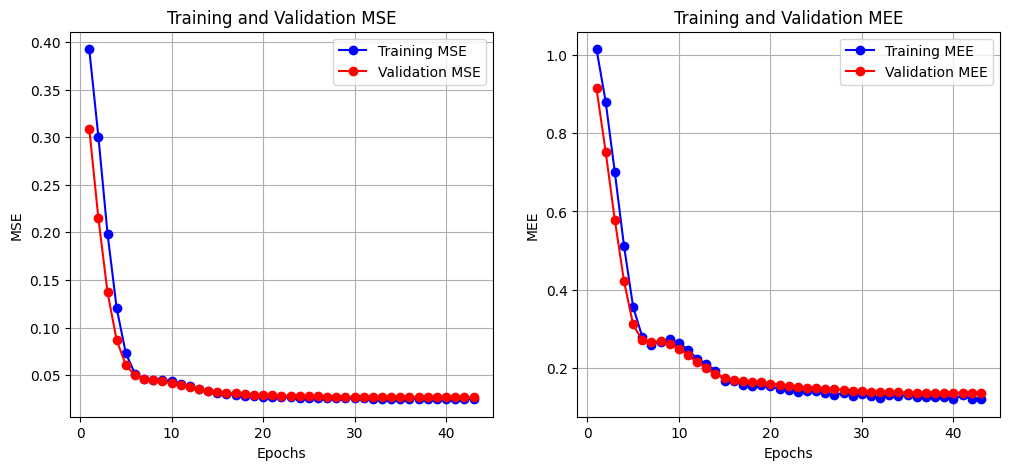

{'learning_rate': 0.006, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hidden_layers': 3, 'momentum': 0.8999999999999999, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 30}
Score: 0.1399474561214447


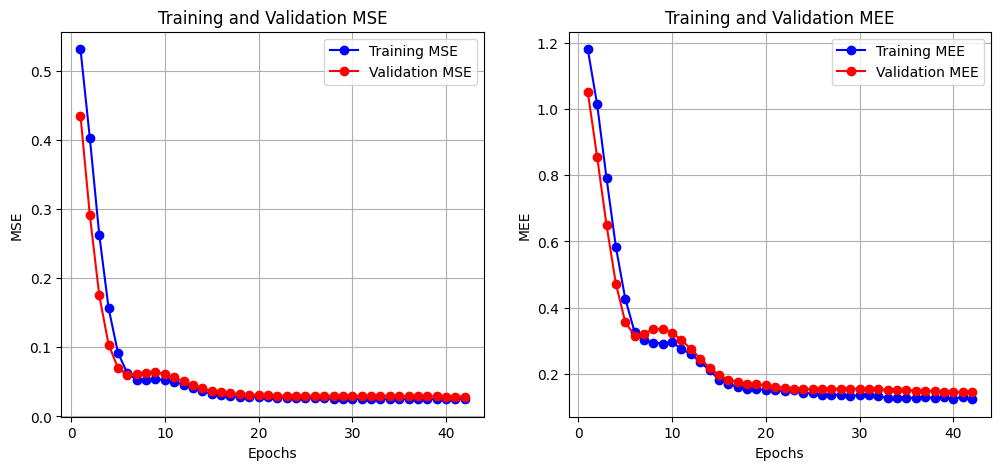

{'learning_rate': 0.007, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hidden_layers': 3, 'momentum': 0.7999999999999999, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 30}
Score: 0.14652087390422822


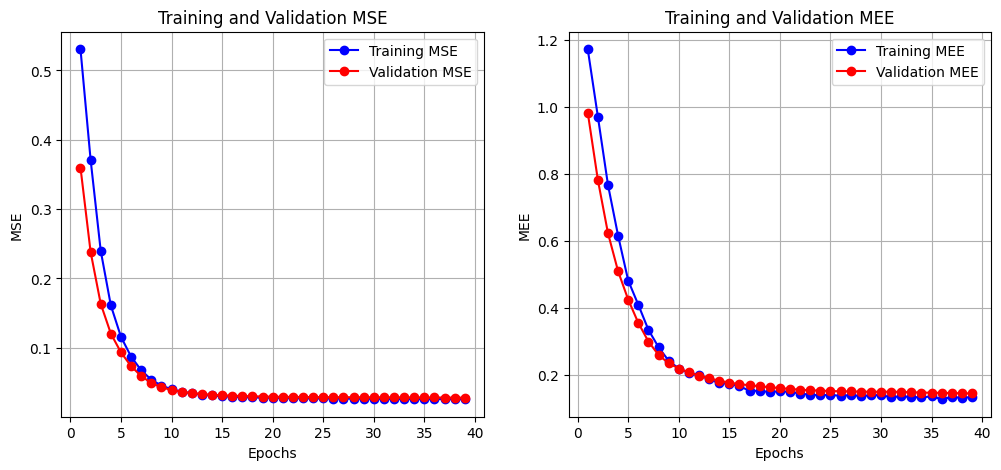

{'learning_rate': 0.007, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hidden_layers': 3, 'momentum': 0.7, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 30}
Score: 0.14909168630838393


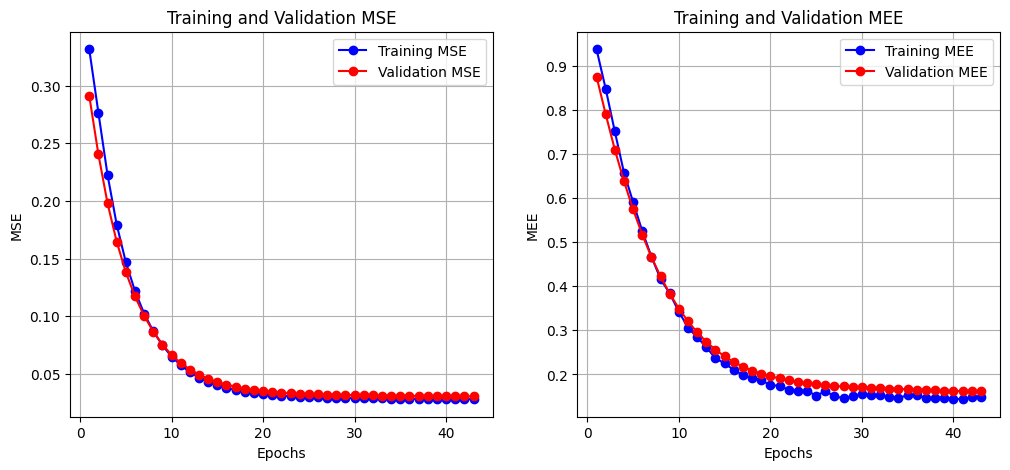

{'learning_rate': 0.006, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hidden_layers': 3, 'momentum': 0.7999999999999999, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 30}
Score: 0.150712251663208


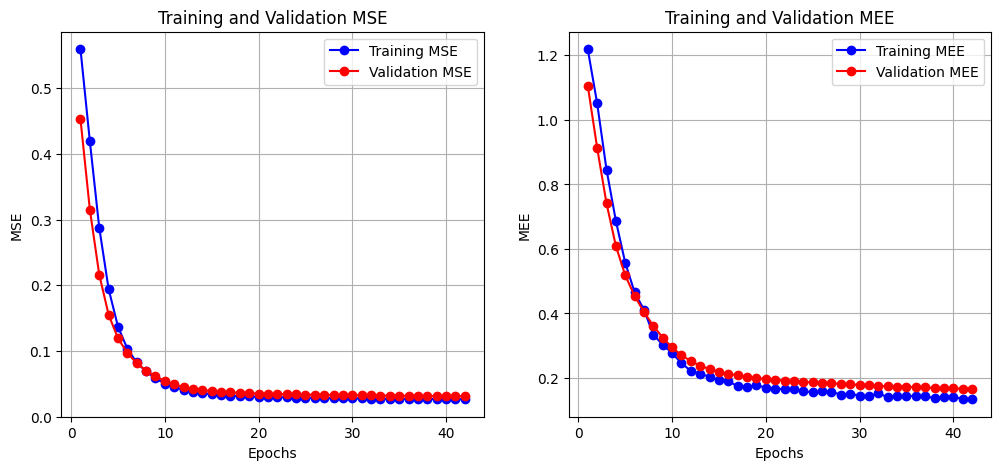

{'learning_rate': 0.007, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hidden_layers': 3, 'momentum': 0.6, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 30}
Score: 0.15530060827732087


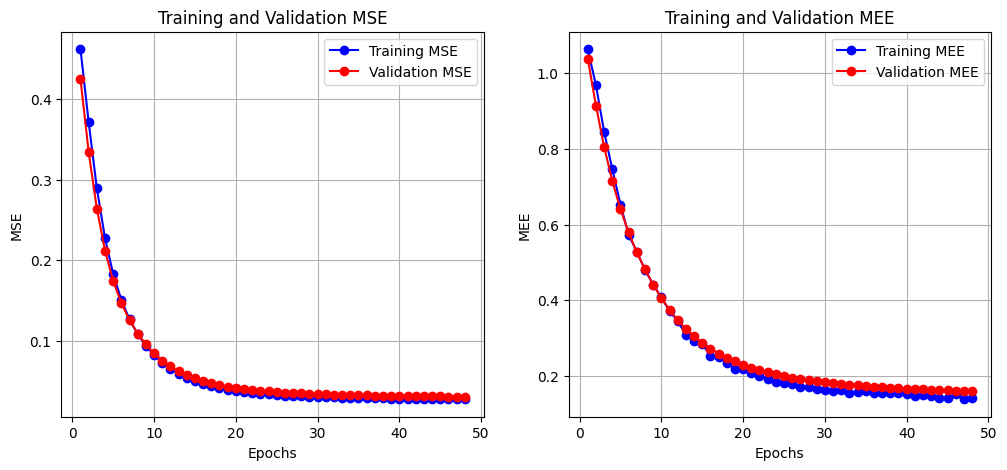

{'learning_rate': 0.006, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hidden_layers': 3, 'momentum': 0.6, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 30}
Score: 0.1635029733181


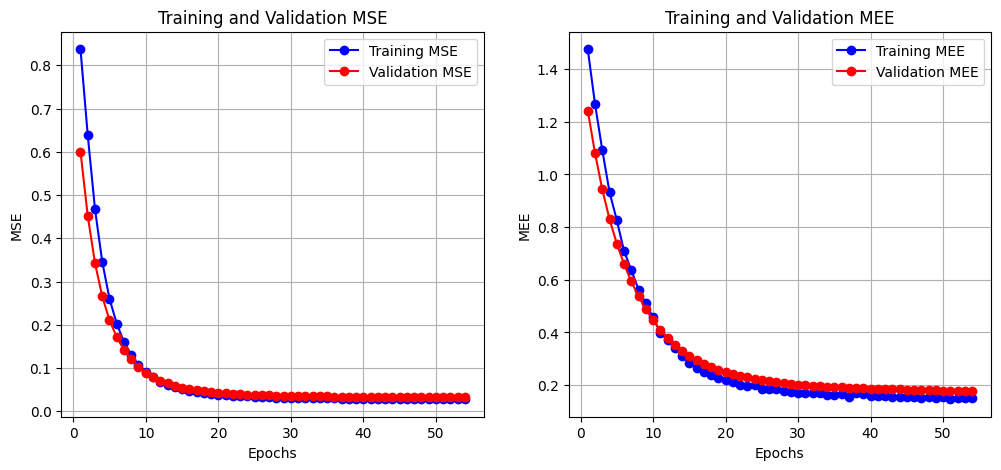

{'learning_rate': 0.006, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hidden_layers': 3, 'momentum': 0.7, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 30}
Score: 0.16858114600181578


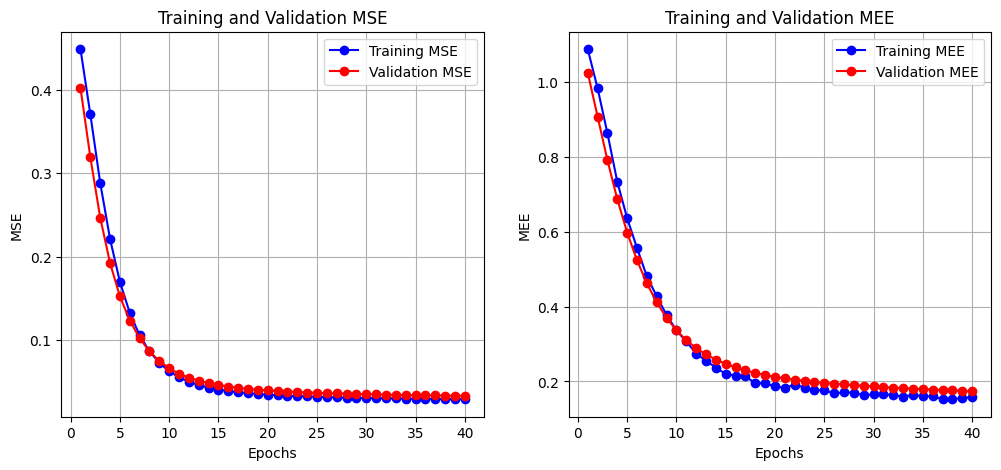

In [19]:
# Determine the input and output sizes based on the scaled training data
input_size = X_train_scaled.shape[1]  # Number of input features
output_size = y_train_scaled.shape[1]  # Number of output features

# Define the ranges for hyperparameters
param_ranges = {
    "learning_rate": (0.006, 0.007, 0.001),  # Learning rate from 0.01 to 0.03 with a step of 0.01
    "epochs": (700, 700, 1),  # Number of epochs fixed at 700
    "batch_size": (128, 128, 1),  # Batch size fixed at 128
    "hidden_size": (80, 80, 1),  # Hidden layer size fixed at 80
    "hidden_layers": (3, 3, 1),  # Number of hidden layers from 2 to 3 with a step of 1
    "momentum": (0.6, 0.9, 0.1),  # Momentum from 0.6 to 0.9 with a step of 0.1
    "regularization": (0.0001, 0.0001, 0.0005),  # Regularization fixed at 0.0001
    "alpha": (0.01, 0.01, 0.01),  # Alpha fixed at 0.01
    "patience": (30, 30, 1)  # Patience fixed at 30
}

# Generate all combinations of hyperparameters based on the specified ranges
param_grid = generate_hyperparameter_combinations(param_ranges)

# Perform greedy search to find the best hyperparameter configurations
best_scores, best_params_list, best_models, best_histories = greed_search(X_train_scaled, y_train_scaled, 
                                                                          'tanh', 'SGD', True, 
                                                                          input_size, output_size, param_grid)

# Print and plot the results for the best hyperparameter configurations
print("--------------------------------------------------Plots--------------------------------------------------")
for i, (history, params, score) in enumerate(zip(best_histories, best_params_list, best_scores)):
    print(f"{params}")  # Print the hyperparameters
    print(f"Score: {score}")  # Print the corresponding score
    plot_training_history(history)  # Plot the training history

## Model assessment

In [20]:
best_models[0].evaluate(X_test_scaled, y_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0320 - mae: 0.0893 - mean_euclidean_error: 0.1887


[0.03195212781429291, 0.08934163302183151, 0.18868453800678253]

In [37]:
# Determine the input and output sizes based on the scaled training data
input_size = X_train_scaled.shape[1]  # Number of input features
output_size = y_train_scaled.shape[1]  # Number of output features

# Define the ranges for hyperparameters
param_ranges_1 = {
    "learning_rate": (0.007, 0.007, 0.001),  # Learning rate from 0.01 to 0.03 with a step of 0.01
    "epochs": (700, 700, 1),  # Number of epochs fixed at 700
    "batch_size": (128, 128, 1),  # Batch size fixed at 128
    "hidden_size": (80, 80, 1),  # Hidden layer size fixed at 80
    "hidden_layers": (3, 3, 1),  # Number of hidden layers from 2 to 3 with a step of 1
    "momentum": (0.9, 0.9, 0.1),  # Momentum from 0.6 to 0.9 with a step of 0.1
    "regularization": (0.0001, 0.0001, 0.0005),  # Regularization fixed at 0.0001
    "alpha": (0.01, 0.01, 0.01),  # Alpha fixed at 0.01
    "patience": (30, 30, 1)  # Patience fixed at 30
}

# Generate all combinations of hyperparameters based on the specified ranges
param_grid_1 = generate_hyperparameter_combinations(param_ranges_1)

double_k_fold_cross_validation(X_train_scaled, y_train_scaled, 'tanh', 'SGD', True, input_size, output_size, 2, 2, param_grid)

([0.1627330631017685, 0.16560812294483185],
 [{'learning_rate': 0.007,
   'epochs': 700,
   'batch_size': 128,
   'hidden_size': 80,
   'hidden_layers': 3,
   'momentum': 0.8999999999999999,
   'regularization': 0.0001,
   'alpha': 0.01,
   'patience': 30},
  {'learning_rate': 0.006,
   'epochs': 700,
   'batch_size': 128,
   'hidden_size': 80,
   'hidden_layers': 3,
   'momentum': 0.8999999999999999,
   'regularization': 0.0001,
   'alpha': 0.01,
   'patience': 30}])